###Objetivo Geral
###Treinar uma rede neural (MLP) para prever a sobrevivência de passageiros do Titanic, explorando problemas de viés e aplicando técnicas de balanceamento e enriquecimento de dados para ###mitigar injustiças no modelo.

##Contexto do Dataset
##Dataset Titanic (Kaggle/Datascience Dojo)
Informações de passageiros do Titanic: nome, sexo, idade, classe social (Pclass), tarifa (Fare), número de parentes a bordo (SibSp e Parch), local de embarque, entre outros.

Variável-alvo: Survived (1 = sobreviveu, 0 = não sobreviveu)

Por que há viés nesse dataset?
Classe social (Pclass): Passageiros da 1ª classe tiveram mais acesso aos botes salva-vidas.

Sexo: Mulheres tiveram prioridade no resgate (“mulheres e crianças primeiro”).

Isso causa viés de representatividade — o modelo pode aprender padrões sociais injustos (ex: associar “ser homem” ou “ser da 3ª classe” com menor chance de sobrevivência).

In [91]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
import numpy as np

sns.set(style="whitegrid")

In [92]:
# Carrega o conjunto de dados Titanic diretamente de um repositório no GitHub
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Seleciona apenas as colunas 'Sex', 'Pclass' e 'Survived', e remove linhas com valores ausentes (NaN)
df = df[['Sex', 'Pclass', 'Survived']].dropna()

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Sexo'] = df['Sex'].map({0: 'Homem', 1: 'Mulher'})
df['Classe'] = df['Pclass'].astype(str)
df['Sobreviveu'] = df['Survived'].map({0: 'Não', 1: 'Sim'})

C:\Users\jmarques\AppData\Local\Temp\ipykernel_12988\3978351522.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette='Set2')


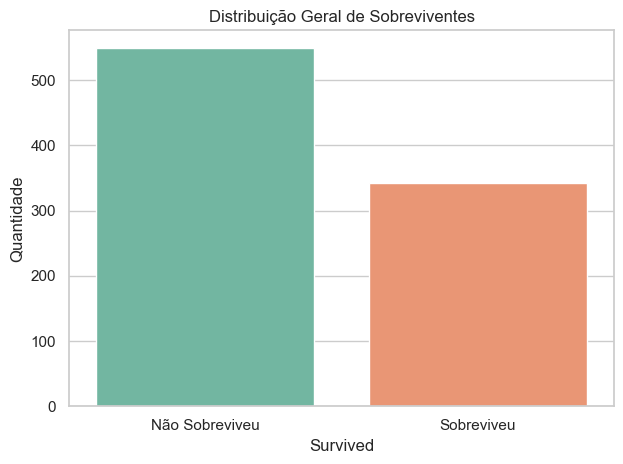

In [93]:
# plot da distribuição geral de sobreviventes
sns.countplot(x='Survived', data=df, palette='Set2')
plt.title("Distribuição Geral de Sobreviventes")
plt.xticks([0, 1], ['Não Sobreviveu', 'Sobreviveu'])
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

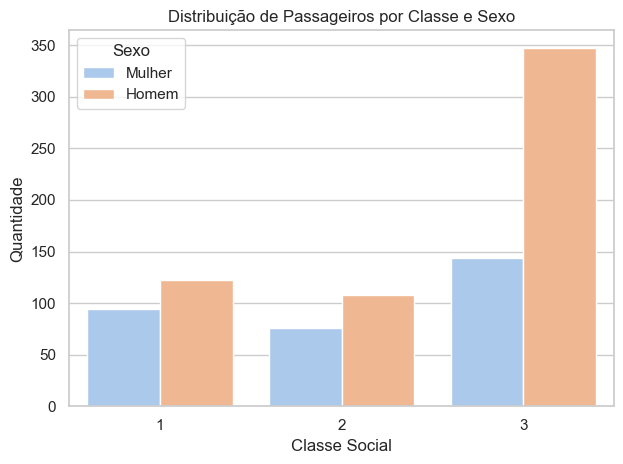

In [94]:
# plot da distribuição por classe e sexo
sns.countplot(x='Pclass', hue='Sexo', data=df, palette='pastel')
plt.title("Distribuição de Passageiros por Classe e Sexo")
plt.xlabel("Classe Social")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

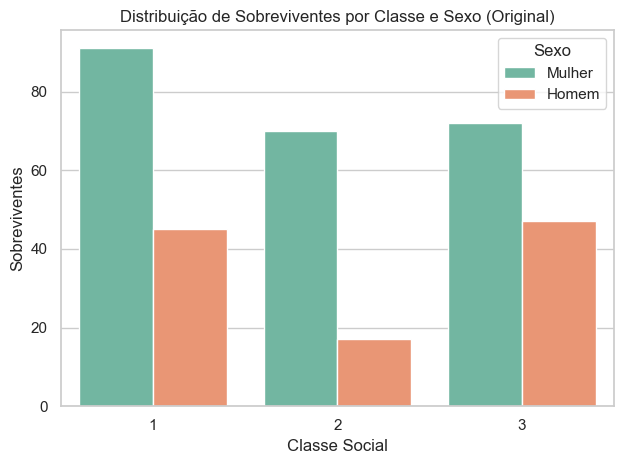

In [95]:
# Sobreviventes por classe e sexo
sobreviventes = df[df['Survived'] == 1]
sns.countplot(x='Pclass', hue='Sexo', data=sobreviventes, palette='Set2')
plt.title("Distribuição de Sobreviventes por Classe e Sexo (Original)")
plt.xlabel("Classe Social")
plt.ylabel("Sobreviventes")
plt.tight_layout()
plt.show()

C:\Users\jmarques\AppData\Local\Temp\ipykernel_12988\2932129216.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pclass', y='Survived', data=proporcao, palette='Blues_d')


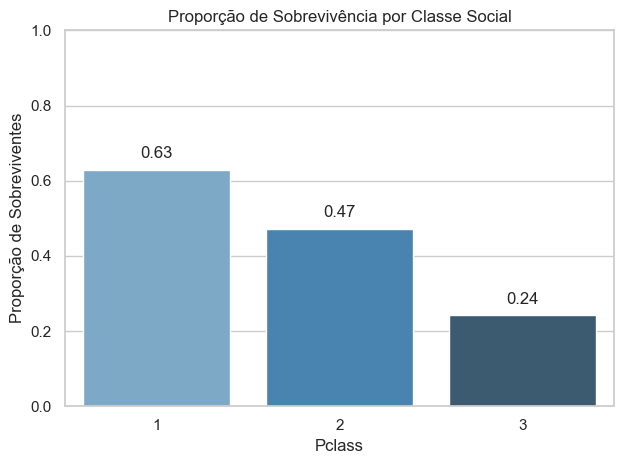

In [96]:
# Proporção de sobreviventes por classe
proporcao = df.groupby('Pclass')['Survived'].mean().reset_index()
sns.barplot(x='Pclass', y='Survived', data=proporcao, palette='Blues_d')
plt.title("Proporção de Sobrevivência por Classe Social")
plt.ylabel("Proporção de Sobreviventes")
plt.ylim(0, 1)
for i, val in enumerate(proporcao['Survived']):
    plt.text(i, val + 0.03, f"{val:.2f}", ha='center')
plt.tight_layout()
plt.show()

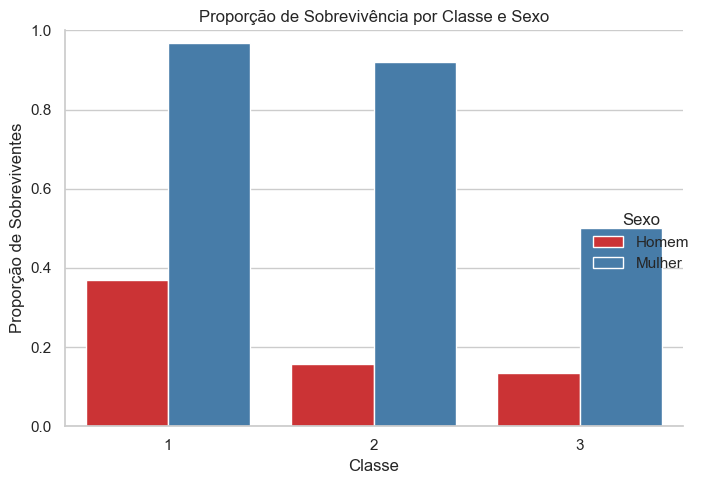

In [97]:
# Proporção de sobreviventes por classe e sexo
proporcao_sexo_classe = df.groupby(['Classe', 'Sexo'])['Survived'].mean().reset_index()
sns.catplot(data=proporcao_sexo_classe, x='Classe', y='Survived', hue='Sexo', kind='bar', palette='Set1', height=5, aspect=1.2)
plt.title("Proporção de Sobrevivência por Classe e Sexo")
plt.ylim(0, 1)
plt.ylabel("Proporção de Sobreviventes")
plt.tight_layout()
plt.show()

In [98]:
#Balanceamento do dataset

df_balanced = pd.DataFrame() 
# Itera sobre cada classe (1ª, 2ª, 3ª) e filtra
for pclass in df['Pclass'].unique(): 
    subset = df[df['Pclass'] == pclass]  # Filtra os dados da classe atual
    survived = subset[subset['Survived'] == 1]  # Filtra os passageiros que sobreviveram
    not_survived = subset[subset['Survived'] == 0]  # Filtra os passageiros que não sobreviveram
    min_len = min(len(survived), len(not_survived))  # Determina o menor grupo para balancear
    balanced_subset = pd.concat([  # Cria subconjunto balanceado por classe
        resample(survived, replace=False, n_samples=min_len, random_state=42),  # Amostra sobreviventes
        resample(not_survived, replace=False, n_samples=min_len, random_state=42)  # Amostra não sobreviventes
    ])
    df_balanced = pd.concat([df_balanced, balanced_subset])  # Adiciona ao DataFrame final

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Embaralha os dados e redefine os índices


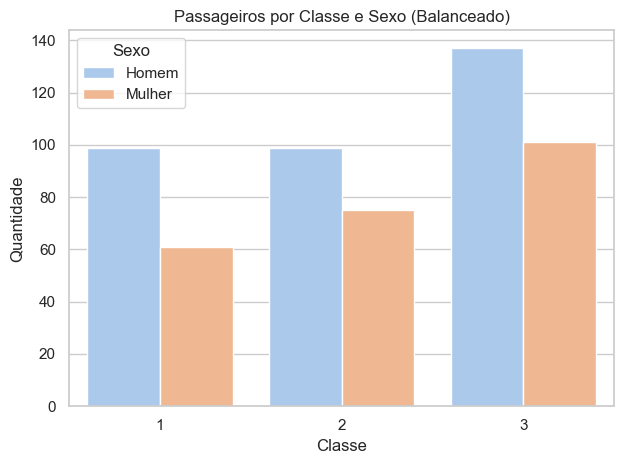

In [99]:
#Gráficos pós-balanceamento

# Passageiros por classe e sexo
sns.countplot(x='Pclass', hue='Sexo', data=df_balanced, palette='pastel')
plt.title("Passageiros por Classe e Sexo (Balanceado)")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()


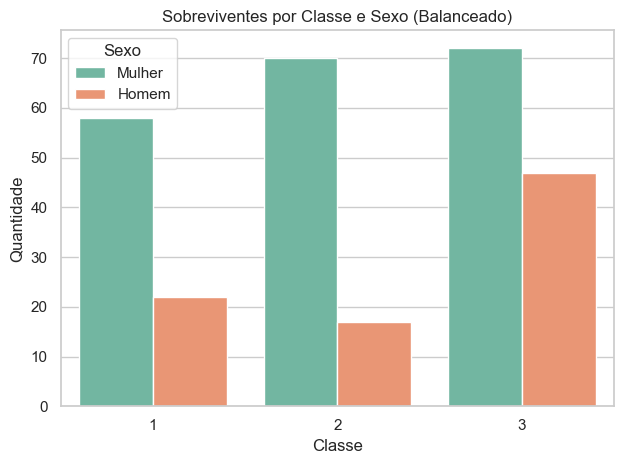

In [100]:
# Sobreviventes por classe e sexo (balanceado)
sobreviventes_bal = df_balanced[df_balanced['Survived'] == 1]
sns.countplot(x='Pclass', hue='Sexo', data=sobreviventes_bal, palette='Set2')
plt.title("Sobreviventes por Classe e Sexo (Balanceado)")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

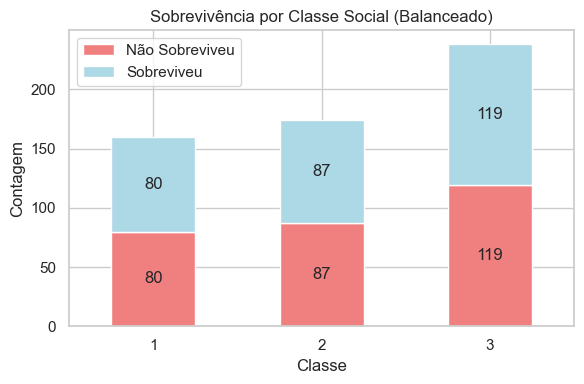

In [101]:
# Stacked bar – sobrevivência por classe
counts = df_balanced.groupby('Pclass')['Survived'].value_counts().unstack().fillna(0)
counts.columns = ['Não Sobreviveu', 'Sobreviveu']
ax = counts.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'], figsize=(6,4))
plt.title("Sobrevivência por Classe Social (Balanceado)")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.xticks(rotation=0)
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.tight_layout()
plt.show()


Balanceamento de Dados (Fairness Básica por Classe)
 O que foi feito:
Criado um novo DataFrame balanceado por classe social (Pclass).

Dentro de cada classe, igualou-se a quantidade de sobreviventes e não sobreviventes.

Por que isso é importante?
Sem balanceamento: o modelo aprende mais com grupos dominantes (maioria).

Com balanceamento: oferece igual peso a grupos desbalanceados -> evita que o modelo “ignore” minorias (como 3ª classe sobrevivente).

Pré-processamento: Divisão e Normalização
Divisão Treino/Teste
train_test_split separa 80% para treino e 20% para teste.

Garante que a performance seja medida em dados nunca vistos, simulando a aplicação real.

Normalização (StandardScaler)
Escala os dados para média 0 e desvio padrão 1.

Importante para redes neurais: evita que variáveis com maior escala (ex: Fare) dominem o cálculo dos gradientes -> acelera e melhora o treinamento.



In [102]:
# Separação e normalização

X = df_balanced[['Sex', 'Pclass']]  # Seleciona as variáveis independentes (features)
y = df_balanced['Survived']  # Seleciona a variável alvo (target)

X_train, X_test, y_train, y_test = train_test_split(  # Divide os dados em treino e teste
    X, y, test_size=0.2, random_state=42)  # 80% treino, 20% teste

scaler = StandardScaler()  # Inicializa o normalizador (padronização)

X_train_scaled = scaler.fit_transform(X_train)  # Ajusta e transforma os dados de treino
X_test_scaled = scaler.transform(X_test)  # Transforma os dados de teste com o mesmo ajuste


Treinamento da Rede Neural (MLPClassifier)
Arquitetura do Modelo
Modelo: MLPClassifier (Multi-Layer Perceptron)

Camadas ocultas: duas camadas com 16 e 8 neurônios, respectivamente

Função de ativação: ReLU (Rectified Linear Unit)

Fórmula: f(x) = max(0, x)

Introduz não-linearidade no modelo

Acelera o aprendizado e evita o problema do gradiente desvanecido (que afeta funções como sigmoid ou tanh)

Permite que o modelo aprenda relações complexas entre as variáveis

Otimizador:
Adam (Adaptive Moment Estimation)
Ajusta os pesos de forma adaptativa
É eficiente e robusto mesmo com muitos parâmetros

2
Iteration 1, loss = 0.80333930
Iteration 2, loss = 0.79339789
Iteration 3, loss = 0.78372205
Iteration 4, loss = 0.77467648
Iteration 5, loss = 0.76584092
Iteration 6, loss = 0.75718384
Iteration 7, loss = 0.74892729
Iteration 8, loss = 0.74118310
Iteration 9, loss = 0.73365802
Iteration 10, loss = 0.72720148
Iteration 11, loss = 0.72060977
Iteration 12, loss = 0.71447992
Iteration 13, loss = 0.70891076
Iteration 14, loss = 0.70399361
Iteration 15, loss = 0.69898154
Iteration 16, loss = 0.69431398
Iteration 17, loss = 0.68961329
Iteration 18, loss = 0.68577561
Iteration 19, loss = 0.68179104
Iteration 20, loss = 0.67784539
Iteration 21, loss = 0.67404007
Iteration 22, loss = 0.67015053
Iteration 23, loss = 0.66652697
Iteration 24, loss = 0.66262253
Iteration 25, loss = 0.65882019
Iteration 26, loss = 0.65495647
Iteration 27, loss = 0.65115437
Iteration 28, loss = 0.64736046
Iteration 29, loss = 0.64364724
Iteration 30, loss = 0.63986439
Iteration 31, loss = 0.63620443
Iteration 32, l

c:\Users\jmarques\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  warnings.warn(


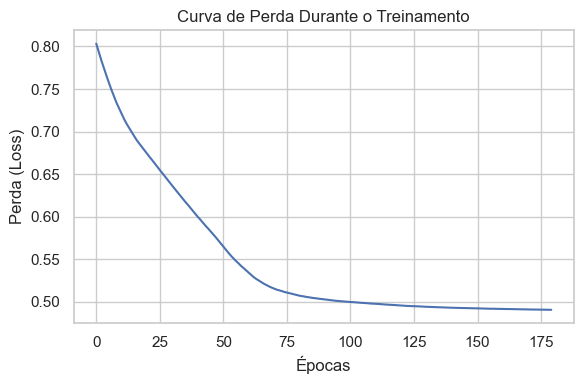

In [103]:
# classificador MLP (rede neural)
print(X_train_scaled.shape[1])  # número de colunas (features)
mlp = MLPClassifier( 
    hidden_layer_sizes=(16, 8), 
    activation='relu',  
    solver='adam',  # Otimizador Adam (baseado em gradiente)
    max_iter=180,  
    random_state=42,  
    early_stopping=False,  # Não interrompe o treino automaticamente se não houver melhoria
    verbose=True, 
)

mlp.fit(X_train_scaled, y_train)  # Treina o modelo com os dados de treino normalizados
plt.figure(figsize=(6, 4))
plt.plot(mlp.loss_curve_)
plt.title("Curva de Perda Durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Perda (Loss)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [104]:
print(X_train_scaled.shape[1])  # número de colunas (features)

2


In [105]:
# Avaliação

y_pred = mlp.predict(X_test_scaled)  

print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}") 
print("\nRelatório de Classificação:") 
print(classification_report(y_test, y_pred))  

Acurácia: 0.8000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.93      0.83        59
           1       0.90      0.66      0.76        56

    accuracy                           0.80       115
   macro avg       0.82      0.80      0.79       115
weighted avg       0.82      0.80      0.80       115



###Métricas do Modelo
Após treinar o modelo, é importante verificar se ele está realmente fazendo boas previsões. Para isso, usamos mais do que apenas a acurácia.

Accuracy (Acurácia): mede a proporção de previsões corretas em relação ao total. Embora útil, pode ser enganosa se uma classe tiver muito mais exemplos que a outra.

Precision (Precisão): indica, entre os casos que o modelo previu como positivos (por exemplo, "sobreviveu"), quantos realmente eram positivos. Alta precisão significa poucos falsos positivos.Precision= VP/VP+FP

Recall (Revocação ou Sensibilidade): mede, entre os casos que realmente eram positivos, quantos o modelo conseguiu identificar corretamente. Alta revocação significa poucos falsos negativos. Recall = VP/VP+FN

F1-Score: é a média harmônica entre precisão e recall. É útil para equilibrar os dois, principalmente quando é importante tanto identificar os positivos quanto evitar falsos alarmes.
F1-Score = 2*(Precision*Recall / Precision+Recall)
Support (Suporte): representa a quantidade real de exemplos de cada classe no conjunto de testes, ajudando a interpretar as métricas anteriores.

Essas métricas juntas fornecem uma visão mais completa da qualidade do modelo, permitindo entender não apenas quantas previsões foram corretas, mas como elas foram corretas (ou erradas).

C:\Users\jmarques\AppData\Local\Temp\ipykernel_12988\373143605.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_result, x='Classe', y='Acurácia', palette='Blues_d')


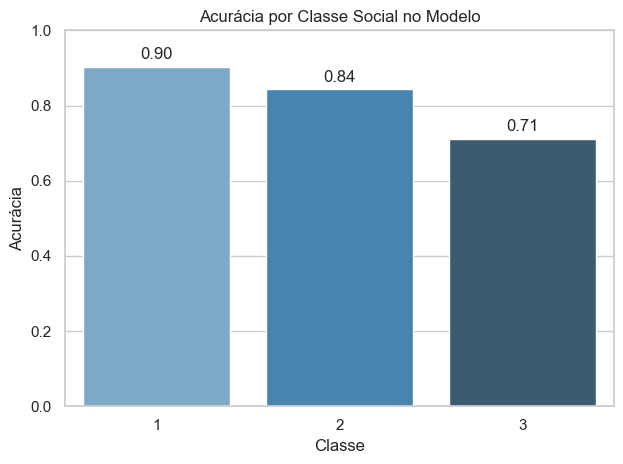

In [106]:
# Avaliação de justiça
def avaliar_justica(model, X_test, y_test, original_df, X_test_scaled):
    X_test_df = X_test.copy()
    X_test_df['Survived_Real'] = y_test.values
    X_test_df['Survived_Pred'] = model.predict(X_test_scaled)
    X_test_df['Pclass'] = original_df.loc[X_test.index, 'Pclass'].values

    resultados = []
    for p in sorted(X_test_df['Pclass'].unique()):
        subset = X_test_df[X_test_df['Pclass'] == p]
        acc = accuracy_score(subset['Survived_Real'], subset['Survived_Pred'])
        resultados.append({'Classe': p, 'Acurácia': acc, 'Total': len(subset)})

    df_result = pd.DataFrame(resultados)
    sns.barplot(data=df_result, x='Classe', y='Acurácia', palette='Blues_d')
    plt.ylim(0, 1)
    plt.title("Acurácia por Classe Social no Modelo")
    for index, row in df_result.iterrows():
        plt.text(index, row.Acurácia + 0.02, f"{row.Acurácia:.2f}", ha='center')
    plt.tight_layout()
    plt.show()

avaliar_justica(mlp, X_test, y_test, df_balanced, X_test_scaled)

In [107]:
# Carregar e preparar o dataset com features extras ---
df_full = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Seleção de colunas relevantes e remoção de valores ausentes
df_full = df_full[['Name', 'Sex', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'Embarked', 'Survived']].dropna()

# Converter sexo para formato numérico
df_full['Sex'] = df_full['Sex'].map({'male': 0, 'female': 1})

# Extrair título do nome para capturar status social
df_full['Title'] = df_full['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
common_titles = ['Mr', 'Mrs', 'Miss', 'Master']
df_full['Title'] = df_full['Title'].apply(lambda t: t if t in common_titles else 'Other')

# One-hot encoding para as colunas categóricas
df_full = pd.get_dummies(df_full, columns=['Embarked', 'Title'], drop_first=True)

# Visualizar as primeiras linhas para checagem
print(df_full.head())

<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
C:\Users\jmarques\AppData\Local\Temp\ipykernel_12988\2476479520.py:11: SyntaxWarning: invalid escape sequence '\.'
  df_full['Title'] = df_full['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


                                                Name  Sex  Pclass   Age  \
0                            Braund, Mr. Owen Harris    0       3  22.0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1       1  38.0   
2                             Heikkinen, Miss. Laina    1       3  26.0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1       1  35.0   
4                           Allen, Mr. William Henry    0       3  35.0   

      Fare  SibSp  Parch  Survived  Embarked_Q  Embarked_S  Title_Miss  \
0   7.2500      1      0         0       False        True       False   
1  71.2833      1      0         1       False       False       False   
2   7.9250      0      0         1       False        True        True   
3  53.1000      1      0         1       False        True       False   
4   8.0500      0      0         0       False        True       False   

   Title_Mr  Title_Mrs  Title_Other  
0      True      False        False  
1     False       True      

C:\Users\jmarques\AppData\Local\Temp\ipykernel_12988\3524835399.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df_mod, palette='Set2')


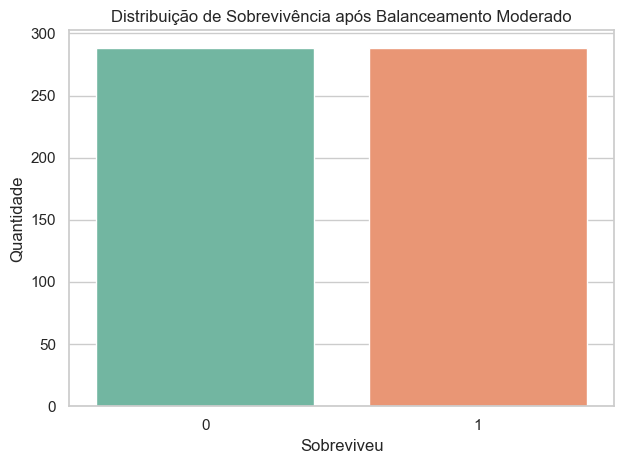

In [108]:
# Balanceamento moderado para mitigar viés ---
survived = df_full[df_full['Survived'] == 1]
not_survived = df_full[df_full['Survived'] == 0]
min_len = min(len(survived), len(not_survived))

df_mod = pd.concat([
    resample(survived, n_samples=min_len, random_state=42),
    resample(not_survived, n_samples=min_len, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Gráfico de verificação pós-balanceamento
sns.countplot(x='Survived', data=df_mod, palette='Set2')
plt.title("Distribuição de Sobrevivência após Balanceamento Moderado")
plt.xlabel("Sobreviveu")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()


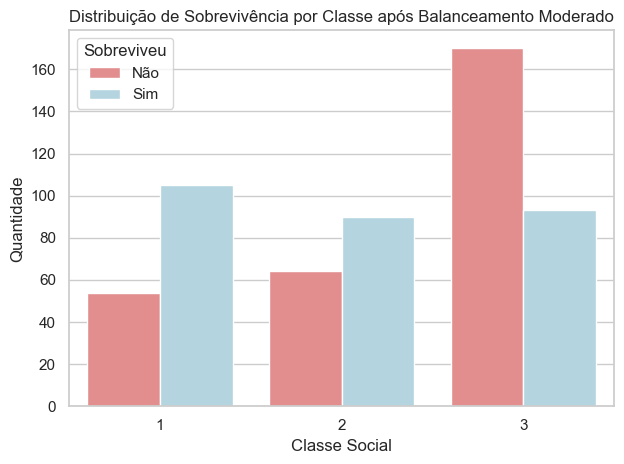

In [109]:
# Gráfico por classe social e sobrevivência
sns.countplot(x='Pclass', hue='Survived', data=df_mod, palette=['lightcoral', 'lightblue'])
plt.title("Distribuição de Sobrevivência por Classe após Balanceamento Moderado")
plt.xlabel("Classe Social")
plt.ylabel("Quantidade")
plt.legend(title='Sobreviveu', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()


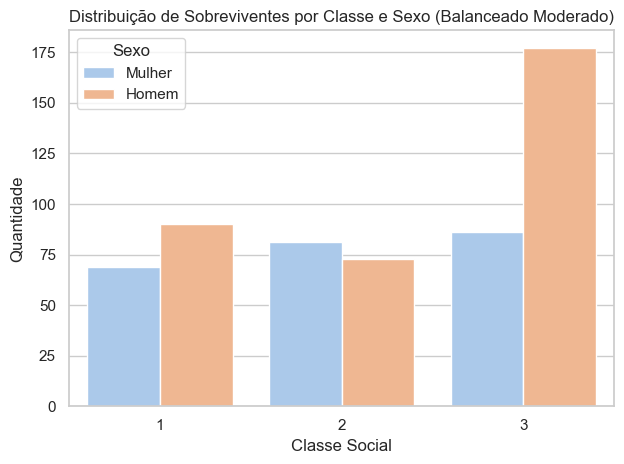

In [110]:
# Mapeia sexo novamente para string (para fins de visualização)
df_mod['Sexo_str'] = df_mod['Sex'].map({0: 'Homem', 1: 'Mulher'})

# Gráfico por classe e sexo
sns.countplot(x='Pclass', hue='Sexo_str', data=df_mod, palette='pastel')
plt.title("Distribuição de Sobreviventes por Classe e Sexo (Balanceado Moderado)")
plt.xlabel("Classe Social")
plt.ylabel("Quantidade")
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

In [111]:
# Separação das features e normalização ---
X = df_mod.drop(columns=['Name', 'Survived', 'Sexo_str'])  # Remove colunas não numéricas
y = df_mod['Survived']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização das features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Shape treino: {X_train_scaled.shape}, Shape teste: {X_test_scaled.shape}")

Shape treino: (460, 12), Shape teste: (116, 12)


12
Iteration 1, loss = 0.70294980
Iteration 2, loss = 0.69582639
Iteration 3, loss = 0.68955767
Iteration 4, loss = 0.68326693
Iteration 5, loss = 0.67757619
Iteration 6, loss = 0.67157105
Iteration 7, loss = 0.66627080
Iteration 8, loss = 0.66117989
Iteration 9, loss = 0.65629435
Iteration 10, loss = 0.65152314
Iteration 11, loss = 0.64691319
Iteration 12, loss = 0.64221922
Iteration 13, loss = 0.63778790
Iteration 14, loss = 0.63350371
Iteration 15, loss = 0.62892665
Iteration 16, loss = 0.62455614
Iteration 17, loss = 0.62009317
Iteration 18, loss = 0.61577848
Iteration 19, loss = 0.61127479
Iteration 20, loss = 0.60676363
Iteration 21, loss = 0.60247618
Iteration 22, loss = 0.59797690
Iteration 23, loss = 0.59349833
Iteration 24, loss = 0.58895773
Iteration 25, loss = 0.58422838
Iteration 26, loss = 0.57921619
Iteration 27, loss = 0.57473751
Iteration 28, loss = 0.56973309
Iteration 29, loss = 0.56509774
Iteration 30, loss = 0.55999832
Iteration 31, loss = 0.55538087
Iteration 32, 

c:\Users\jmarques\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  warnings.warn(


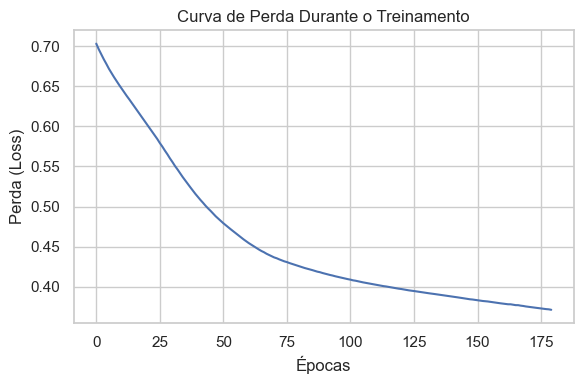

In [ ]:
# Treinamento do MLP com as features enriquecidas 
print(X_train_scaled.shape[1])  # número de colunas (features)
mlp_enriched = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    max_iter=180,
    random_state=42,
    early_stopping=False,
    verbose=True
)

mlp_enriched.fit(X_train_scaled, y_train)
# Curva de perda
plt.figure(figsize=(6, 4))
plt.plot(mlp_enriched.loss_curve_)
plt.title("Curva de Perda Durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Perda (Loss)")
plt.grid(True)
plt.tight_layout()
plt.show()


 Modelo Enriquecido com Features Adicionais
Acurácia: 0.8448
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        60
           1       0.87      0.80      0.83        56

    accuracy                           0.84       116
   macro avg       0.85      0.84      0.84       116
weighted avg       0.85      0.84      0.84       116



C:\Users\jmarques\AppData\Local\Temp\ipykernel_12988\373143605.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_result, x='Classe', y='Acurácia', palette='Blues_d')


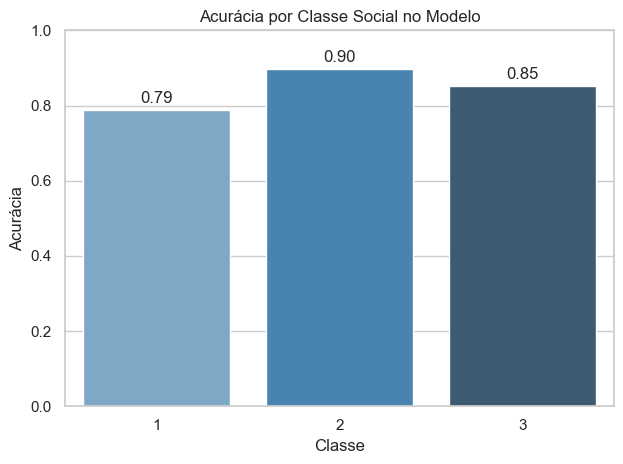

In [113]:
# Predição com o modelo mlp_enriched
y_pred_enriched = mlp_enriched.predict(X_test_scaled)

print("\n Modelo Enriquecido com Features Adicionais")
print(f"Acurácia: {accuracy_score(y_test, y_pred_enriched):.4f}")
print(classification_report(y_test, y_pred_enriched))

# Avaliação de justiça por classe social para o modelo enriquecido
avaliar_justica(mlp_enriched, X_test, y_test, df_mod, X_test_scaled)


C:\Users\jmarques\AppData\Local\Temp\ipykernel_12988\2221164153.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_result, x='Sexo', y='Acurácia', palette='Set2')


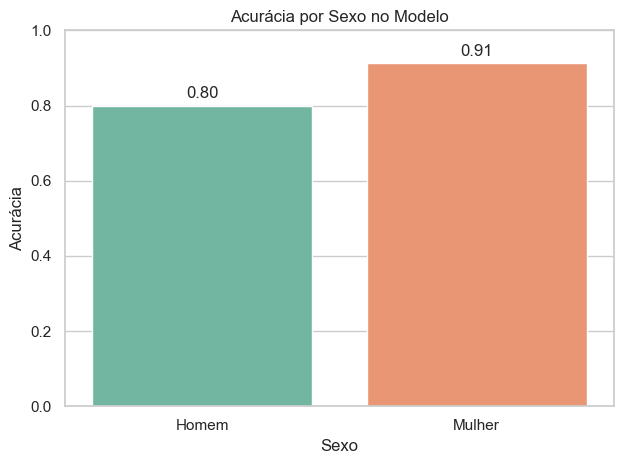

In [114]:
def avaliar_justica_por_sexo(model, X_test, y_test, original_df, X_test_scaled):
    X_test_df = X_test.copy()
    X_test_df['Survived_Real'] = y_test.values
    X_test_df['Survived_Pred'] = model.predict(X_test_scaled)
    X_test_df['Sex'] = original_df.loc[X_test.index, 'Sex'].values
    X_test_df['Sexo'] = X_test_df['Sex'].map({0: 'Homem', 1: 'Mulher'})

    resultados = []
    for s in sorted(X_test_df['Sex'].unique()):
        subset = X_test_df[X_test_df['Sex'] == s]
        acc = accuracy_score(subset['Survived_Real'], subset['Survived_Pred'])
        resultados.append({'Sexo': 'Homem' if s == 0 else 'Mulher', 'Acurácia': acc, 'Total': len(subset)})

    df_result = pd.DataFrame(resultados)

    sns.barplot(data=df_result, x='Sexo', y='Acurácia', palette='Set2')
    plt.ylim(0, 1)
    plt.title("Acurácia por Sexo no Modelo")
    for index, row in df_result.iterrows():
        plt.text(index, row.Acurácia + 0.02, f"{row.Acurácia:.2f}", ha='center')
    plt.tight_layout()
    plt.show()

avaliar_justica_por_sexo(mlp_enriched, X_test, y_test, df_mod, X_test_scaled)
